# Import packages and modules

In [3]:
#Various packages I have used for different methods. (May not all still be necessary, but keeping in anyway). 
import cobra
import matplotlib.pyplot as plt
from cobra import sampling
import numpy as np
import csv
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra import Model, Reaction, Metabolite
import pandas as pd
import gurobipy as gp
from pandas import DataFrame
import csv
from cobra.util.solver import linear_reaction_coefficients
from cobra import sampling
from time import time
import cobra.test
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import statistics
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
sns.set()

# Import and dissect proteomics dataset

In [4]:
ensembl_proteomics = pd.read_csv('/Users/katemeeson/Dropbox (The University of Manchester)/UNIMAN Ovarian Cancer Project/July August modelling/ensembl_proteomics.csv')

FC0_ensembl = ensembl_proteomics.iloc[:,0:3]
FC100_ensembl = ensembl_proteomics.iloc[:,[3,4,5]]
FC500_ensembl = ensembl_proteomics.iloc[:,[6,7,8]]

FC0_transposed_ensembl = FC0_ensembl.transpose() #orientation for dataframe to dictionary conversion. 
FC100_transposed_ensembl = FC100_ensembl.transpose()
FC500_transposed_ensembl = FC500_ensembl.transpose()

FC0_dict_ensembl = FC0_transposed_ensembl.to_dict('list')
FC100_dict_ensembl = FC100_transposed_ensembl.to_dict('list')
FC500_dict_ensembl = FC500_transposed_ensembl.to_dict('list')

print('FC0_dict: ', len(FC0_dict_ensembl))
print('FC100_dict: ', len(FC100_dict_ensembl))
print('FC500_dict: ', len(FC500_dict_ensembl))
ensembl_proteomics

FC0_dict:  2584
FC100_dict:  2584
FC500_dict:  2584


,To,1_FC0_UNIMAN,2_FC0_UNIMAN,3_FC0_UNIMAN,1_FC100_UNIMAN,2_FC100_UNIMAN,3_FC100_UNIMAN,1_FC500_UNIMAN,2_FC500_UNIMAN,3_FC500_UNIMAN
0,ENSG00000151247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.338929,27.840268,40.798217
1,ENSG00000135406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.669405,10.311900,9.692083
2,ENSG00000185885,0.000000,0.000000,0.000000,141.100707,67.453476,105.257364,303.739613,328.885556,466.076144
3,ENSG00000133265,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.487784,30.054430,17.224477
4,ENSG00000146926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.214768,26.830506,41.484865
...,...,...,...,...,...,...,...,...,...,...
2579,ENSG00000184672,1593.522699,1638.521402,1896.864108,1919.050812,1700.629152,1528.883639,1855.953411,1657.173839,1746.453669
2580,ENSG00000041357,2614.265573,2371.116841,2903.682742,2854.571929,2629.230894,2432.919882,2712.630778,2301.219410,2723.346094
2581,ENSG00000135069,1631.154876,1161.950609,1601.933527,1470.429285,1445.948679,1380.361747,1419.556933,1405.996717,1475.284532
2582,ENSG00000106028,4709.911145,4519.158264,5276.965994,5028.942079,4677.706556,4566.271020,4750.747272,4584.395249,5007.843829


In [23]:
FC0_ensembl = ensembl_proteomics.iloc[:,[0,1,2,3]]
FC100_ensembl = ensembl_proteomics.iloc[:,[0,4,5,6]]
FC500_ensembl = ensembl_proteomics.iloc[:,[0,7,8,9]]

#Convert lists of values to dictionaries. 
FC0_list = FC0_ensembl.set_index('To').T.to_dict('list')
FC100_list = FC100_ensembl.set_index('To').T.to_dict('list')
FC500_list = FC500_ensembl.set_index('To').T.to_dict('list')

FC0 = {}  
for key, val in FC0_list.items():
    FC0[key] = np.average(val)
        
FC100 = {}
for key, val in FC100_list.items():
    FC100[key] = np.average(val)
        
FC500 = {}
for key, val in FC500_list.items():
    FC500[key] = np.average(val)
        
print('Number of detected proteins')
print('---------------------------')
print('FC0 = ', len(FC0))
print('FC100 = ', len(FC100))
print('FC500 = ', len(FC500))

<ipython-input-23-a7ff03e0463b>:5: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  FC0_list = FC0_ensembl.set_index('To').T.to_dict('list')
<ipython-input-23-a7ff03e0463b>:6: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  FC100_list = FC100_ensembl.set_index('To').T.to_dict('list')
<ipython-input-23-a7ff03e0463b>:7: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  FC500_list = FC500_ensembl.set_index('To').T.to_dict('list')


Number of detected proteins
---------------------------
FC0 =  2583
FC100 =  2583
FC500 =  2583


# Import Human1 model

In [205]:
model = cobra.io.read_sbml_model('Human-GEM-annotated.xml')
model

Name,HumanGEM
Memory address,0x0138c0b610
Number of metabolites,8400
Number of reactions,13096
Number of groups,143
Objective expression,1.0*biomass_human - 1.0*biomass_human_reverse_fb2f2
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [225]:
#shortcuts to access reactions and metabolites
x = model.reactions.get_by_id
y = model.metabolites.get_by_id

## Getting an overview of the Human1 model

In [7]:
print("Reactions:", len(model.reactions))
print("Metabolites:", len(model.metabolites))
print("Genes:", len(model.genes))
print(model.compartments)

Reactions: 13096
Metabolites: 8400
Genes: 3628
{'c': 'Cytosol', 's': 'Extracellular', 'l': 'Lysosome', 'r': 'Endoplasmic reticulum', 'm': 'Mitochondria', 'p': 'Peroxisome', 'g': 'Golgi apparatus', 'n': 'Nucleus', 'c_i': 'Inner mitochondria'}


In [10]:
print(model.summary())

Objective
1.0 biomass_human = 187.35362997658078

Uptake
------
 Metabolite          Reaction      Flux  C-Number C-Flux
    m00350s EX_13_cis_retn[e]   0.01938        20  0.00%
    m01417s EX_1a25dhvitd3[e]  0.003867        27  0.00%
    m00674s         EX_2pg[e]    0.3261         3  0.00%
    m01231s      EX_CE1617[e]  0.003867        20  0.00%
    m02479s     EX_HC00900[e]     867.9         4  1.23%
    m02965s     EX_HC02192[e]     246.1        26  2.26%
    m02000s     EX_HC02193[e]      1000        26  9.20%
    m02871s       EX_ahcys[e]      1000        14  4.95%
    m01371s         EX_atp[e]      1000        10  3.54%
    m02635s       EX_c4crn[e]      1000        11  3.89%
    m02409s       EX_c8crn[e]     118.2        15  0.63%
    m01430s      EX_crm_hs[e]     27.61        19  0.19%
    m01644s        EX_dcmp[e]     532.6         9  1.70%
    m01690s        EX_dhap[e]     0.773         3  0.00%
    m01802s         EX_fad[e]   0.01551        27  0.00%
    m01831s        EX_fa

In [11]:
#any in-built constraints? 
in_built_constraints = {} 

for r in model.reactions:
    if r.bounds != (0.0, 0.0) and r.bounds != (-1000.0, 0.0) and r.bounds != (-1000.0, 1000.0) and r.bounds != (0.0, 1000.0):
        in_built_constraints[r.id] = r.bounds
        print(r.id)

if len(in_built_constraints) == 0:
    print('No in-built constraints')

No in-built constraints


In [13]:
#what proportion of the model is annotated with reaction rules, and what are these rules? 
ANDs = []
ORs = []
ANDORs = []
one_gene = []
no_gene = []

for r in model.reactions:
    if 'and' in r.gene_reaction_rule and 'or' not in r.gene_reaction_rule:
        ANDs.append(r.id)
    if 'and' in r.gene_reaction_rule and 'or' in r.gene_reaction_rule:
        ANDORs.append(r.id)
    if 'or' in r.gene_reaction_rule and 'and' not in r.gene_reaction_rule:
        ORs.append(r.id)
    if len(r.gene_reaction_rule) == 0:
        no_gene.append(r.id)
    if len(r.gene_reaction_rule) != 0:
        if 'or' in r.gene_reaction_rule:
            continue
        elif 'and' in r.gene_reaction_rule:
            continue
        else:
            one_gene.append(r.id)

print('AND rules: ', len(ANDs))
print('ANDOR rules: ', len(ANDORs))
print('OR rules: ', len(ORs))
print('ONE GENE rules: ', len(one_gene))
print('NO GENE rules: ', len(no_gene))
print('Proportion of model not annotated: ', len(no_gene)/len(model.reactions)*100, '%')
print('Proportion of model which IS annotated: ', 100-(len(no_gene)/len(model.reactions)*100), '%')
print('Total Reactions = ', len(model.reactions))
print(len(ORs)+len(ANDs)+len(ANDORs)+len(one_gene)+len(no_gene))

AND rules:  653
ANDOR rules:  129
OR rules:  3972
ONE GENE rules:  3282
NO GENE rules:  5060
Proportion of model not annotated:  38.63775198533904 %
Proportion of model which IS annotated:  61.36224801466096 %
Total Reactions =  13096
13096


## What is the coverage of model reactions by our proteomics and vice versa?

In [25]:
#function to match proteomics data to model reaction rules. 

def gene_expression_match(lis, data, lib): #lis = list (ANDs, ORs, ANDORs or ones), data = expression data,  
    for r in lis:                          #lib = library you are making
        ins= {}
        notins = {}
        for g in x(r).genes:
            for key, val in data.items():
                if key in str(g):
                    ins[str(g)] = val
                if key not in str(g):
                    notins[str(g)] = 'NO DATA'
        temp = {**notins, **ins}
        lib[r] = temp

In [26]:
#making libraries containing reaction rules, with proteins annotated. 

FC0_ones = {}
FC100_ones = {}
FC500_ones = {}

gene_expression_match(one_gene, FC0, FC0_ones)
gene_expression_match(one_gene, FC100, FC100_ones)
gene_expression_match(one_gene, FC500, FC500_ones)

FC0_ANDs = {}
FC100_ANDs = {}
FC500_ANDs = {}

gene_expression_match(ANDs, FC0, FC0_ANDs) 
gene_expression_match(ANDs, FC100, FC100_ANDs)
gene_expression_match(ANDs, FC500, FC500_ANDs)

FC0_ORs = {}
FC100_ORs = {}
FC500_ORs = {}

gene_expression_match(ORs, FC0, FC0_ORs)
gene_expression_match(ORs, FC100, FC100_ORs)
gene_expression_match(ORs, FC500, FC500_ORs)

FC0_ANDORs = {}
FC100_ANDORs = {}
FC500_ANDORs = {}

gene_expression_match(ANDORs, FC0, FC0_ANDORs)
gene_expression_match(ANDORs, FC100, FC100_ANDORs)
gene_expression_match(ANDORs, FC500, FC500_ANDORs)

In [27]:
#functions to assess coverage of model reactions by our proteomics data. 

def match_ANDs(a): # outputs 2 lists, one with reactions with all genes matched, and one where at least one gene is matched
    
    matched_ANDs = []
    fully_matched_ANDs = []

    for key, val in a.items():
        n = 0
        for k, v in val.items():
            if type(v) != str:
                n = n+1
        if n == len(x(key).genes):
            fully_matched_ANDs.append(key)
        if n != 0:
            matched_ANDs.append(key)
        
    return matched_ANDs, fully_matched_ANDs

def match(lib):

    matched = []

    for key, val in lib.items():
        n = 0
        for k, v in val.items():
            if type(v) != str:
                n = n+1
        if n != 0:
            matched.append(key)
    return matched


def coverage(a, o, ao, on): # a = ANDs, o = ORs, ao = ANDORs, on = ones 
    
    annotated_reactions = [] #checking how many reactions have a gene annotated
    for r in model.reactions:
        n = 0
        for g in r.genes:
            if len(str(g)) > 0:
                n = n+1
        if n > 1:
            annotated_reactions.append(r.id)
            
    matched_ANDs, fully_matched_ANDs = match_ANDs(a)
    matched_ORs = match(o)
    matched_ANDORs = match(ao)
    matched_ones = match(on)
    
    total_matched = [len(fully_matched_ANDs), len(matched_ORs), len(matched_ones), len(matched_ANDORs)]
    total_partially_matched  = [len(matched_ANDs), len(matched_ORs), len(matched_ones), len(matched_ANDORs)]

    print('Reactions in Model = ', len(model.reactions))
    print('Models annotated with at least one gene = ', len(annotated_reactions))
    print('Coverage with fully matched "Ands" = ', np.sum(total_matched))
    print('Coverage with partially matched "Ands" = ', np.sum(total_partially_matched))

In [28]:
print('FC0 Coverage')
print('---------------')
coverage(FC0_ANDs, FC0_ORs, FC0_ANDORs, FC0_ones)
print('')
print('FC100 Coverage')
print('----------------')
coverage(FC100_ANDs, FC100_ORs, FC100_ANDORs, FC100_ones)
print('')
print('FC500 Coverage')
print('----------------')
coverage(FC500_ANDs, FC500_ORs, FC500_ANDORs, FC500_ones)

FC0 Coverage
---------------
Reactions in Model =  13096
Models annotated with at least one gene =  4754
Coverage with fully matched "Ands" =  2538
Coverage with partially matched "Ands" =  2876

FC100 Coverage
----------------
Reactions in Model =  13096
Models annotated with at least one gene =  4754
Coverage with fully matched "Ands" =  2538
Coverage with partially matched "Ands" =  2876

FC500 Coverage
----------------
Reactions in Model =  13096
Models annotated with at least one gene =  4754
Coverage with fully matched "Ands" =  2538
Coverage with partially matched "Ands" =  2876


In [29]:
FC0_expression_vals = []
for key, val in FC0.items():
    FC0_expression_vals.append(val)
    
FC100_expression_vals = []
for key, val in FC100.items():
    FC100_expression_vals.append(val)
    
FC500_expression_vals = []
for key, val in FC500.items():
    FC500_expression_vals.append(val)
    
FC0_expression_vals.sort()
FC100_expression_vals.sort()
FC500_expression_vals.sort()

print('Max FC0 = ', FC0_expression_vals[-1])
print('Max FC100 = ', FC100_expression_vals[-1])
print('Max FC500 = ', FC500_expression_vals[-1])

Max FC0 =  90748.11355666666
Max FC100 =  73461.95941666666
Max FC500 =  59900.516429999996


## Finding the number of core reactions in Human1 model

In [16]:
#Original FBA solution, when optimised for biomass production. 
model.objective = x('biomass_human')
solution = model.optimize()
original_biomass_solution = (solution['biomass_human'])
print('Original FBA solution optimised for biomass production: ', original_biomass_solution)

core_reactions = []

for r in model.reactions:
    if solution[r.id] != 0:
        core_reactions.append(r.id) #if the FBA solution is never 0, reactions is labelled essential. 

print('Number of core reactions: ', len(core_reactions))

Original FBA solution optimised for biomass production:  187.35362997658078
Number of core reactions:  838


## What is the coverage of the CORE reactions by our proteomics?  

In [30]:
matched_ANDs, fully_matched_ANDs = match_ANDs(FC0_ANDs)
matched_ORs = match(FC0_ORs)
matched_ANDORs = match(FC0_ANDORs)
matched_ones = match(FC0_ones)

model.objective = 'biomass_human'
print(model.objective)

all_matched = matched_ANDs + matched_ANDORs + matched_ORs + matched_ones

matched_core_reactions = []

for r in core_reactions:
    if r in all_matched:
        matched_core_reactions.append(r)

print('Number of core reactions = ', len(core_reactions))
print('Coverage of core reactions = ', len(matched_core_reactions))

Maximize
1.0*biomass_human - 1.0*biomass_human_reverse_fb2f2
Number of core reactions =  838
Coverage of core reactions =  187


## Scaling the proteomics dataset, according to highest expression value

### Scaling FC0

In [46]:
#printing the highest value of FC0 samples, and the corresponding reactions. 
#highest expression value will be used for scaling

high = []

for key, val in FC0.items():
    high.append(val)
    
high.sort()

for key, val in FC0.items():
    if val == high[-1]:
        for r in model.reactions:
            if key in r.gene_reaction_rule and r.id in all_matched:
                print(r.name, ', ', key, ': ', val)
                
print(high[-1])

 <--> 1.0 UTP ,  ENSG00000153201 :  90748.11355666666
 <--> 1.0 DNA ,  ENSG00000153201 :  90748.11355666666
90748.11355666666


In [35]:
def scale(x): # x = library
    dic1 = {}
    for key, val in x.items():
        dic2 = {}
        dic3 = {}
        for k, v in val.items():
            if type(v) != str:
                dic2[k] = (v / 90748.11355666666) * 100
            else:
                dic3[k] = 'NO DATA'
        dic1[key] = {**dic2, **dic3}
    return dic1

FC0_ANDs_scaled = scale(FC0_ANDs)
FC0_ORs_scaled = scale(FC0_ORs)
FC0_ones_scaled = scale(FC0_ones)
FC0_ANDORs_scaled = scale(FC0_ANDORs)

print(len(FC0_ANDs_scaled))
print(len(FC0_ORs_scaled))
print(len(FC0_ones_scaled))
print(len(FC0_ANDORs_scaled))

653
3972
3282
129


In [36]:
# Creating a dictionary with reaction ID's and the LOWEST expression value
FC0_ANDs_constrain_full_matched = {}
for key, val in FC0_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC0_ANDs_constrain_full_matched[key] = l[0]

#same as above but not zeroing reactions with missing genes
FC0_ANDs_constrain = {}
for key, val in FC0_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC0_ANDs_constrain[key] = l[0]
    
#Creating a dictionary with reaction ID's and the HIGHEST expression value
FC0_ORs_constrain = {}
for key, val in FC0_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC0_ORs_constrain[key] = l[0]
        
#constraining ANDORs to highest or lowest
FC0_ANDORs_constrain_low = {}
for key, val in FC0_ANDORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC0_ANDORs_constrain_low[key] = l[0]
        
FC0_ANDORs_constrain_high = {}
for key, val in FC0_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC0_ANDORs_constrain_high[key] = l[0]
        
#simplifying single gene ones

FC0_ones_constrain = {}
for key, val in FC0_ones_scaled.items():
    for k, v in val.items():
        if v == 'NO DATA':
            FC0_ones_constrain[key] = 0
        else:
            FC0_ones_constrain[key] = v

### Scaling FC100

In [45]:
high = []

for key, val in FC100.items():
    high.append(val)
    
high.sort()

for key, val in FC100.items():
    if val == high[-1]:
        for r in model.reactions:
            if key in r.gene_reaction_rule and r.id in all_matched:
                print(r.name, ', ', key, ': ', val) 
                
print(high[-1])

 <--> 1.0 UTP ,  ENSG00000153201 :  73461.95941666666
 <--> 1.0 DNA ,  ENSG00000153201 :  73461.95941666666
73461.95941666666


In [51]:
def scale(x): # x = library
    dic1 = {}
    for key, val in x.items():
        dic2 = {}
        dic3 = {}
        for k, v in val.items():
            if type(v) != str:
                dic2[k] = (v / 73461.95941666666) * 100
            else:
                dic3[k] = 'NO DATA'
        dic1[key] = {**dic2, **dic3}
    return dic1

FC100_ANDs_scaled = scale(FC100_ANDs)
FC100_ORs_scaled = scale(FC100_ORs)
FC100_ones_scaled = scale(FC100_ones)
FC100_ANDORs_scaled = scale(FC100_ANDORs)

print(len(FC100_ANDs_scaled))
print(len(FC100_ORs_scaled))
print(len(FC100_ones_scaled))
print(len(FC100_ANDORs_scaled))

653
3972
3282
129


In [49]:
# Creating a dictionary with reaction ID's and the LOWEST expression value
FC100_ANDs_constrain_full_matched = {}
for key, val in FC100_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC100_ANDs_constrain_full_matched[key] = l[0]

#same as above but not zeroing reactions with missing genes
FC100_ANDs_constrain = {}
for key, val in FC100_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC100_ANDs_constrain[key] = l[0]
    
#Creating a dictionary with reaction ID's and the HIGHEST expression value
FC100_ORs_constrain = {}
for key, val in FC100_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC100_ORs_constrain[key] = l[0]
        
#constraining ANDORs to highest or lowest (cant b arsed to figure out a better way currently :))
FC100_ANDORs_constrain_low = {}
for key, val in FC100_ANDORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC100_ANDORs_constrain_low[key] = l[0]
        
FC100_ANDORs_constrain_high = {}
for key, val in FC100_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC100_ANDORs_constrain_high[key] = l[0]
        
#simplifying single gene ones

FC100_ones_constrain = {}
for key, val in FC100_ones_scaled.items():
    for k, v in val.items():
        if v == 'NO DATA':
            FC100_ones_constrain[key] = 0
        else:
            FC100_ones_constrain[key] = v

### Scaling FC500

In [48]:
high = []

for key, val in FC500.items():
    high.append(val)
    
high.sort()

for key, val in FC500.items():
    if val == high[-1]:
        for r in model.reactions:
            if key in r.gene_reaction_rule and r.id in all_matched:
                print(r.name, ', ', key, ': ', val)
                
print(high[-1])

59900.516429999996


In [53]:
def scale(x): # x = library
    dic1 = {}
    for key, val in x.items():
        dic2 = {}
        dic3 = {}
        for k, v in val.items():
            if type(v) != str:
                dic2[k] = (v / 59900.516429999996) * 100
            else:
                dic3[k] = 'NO DATA'
        dic1[key] = {**dic2, **dic3}
    return dic1

FC500_ANDs_scaled = scale(FC500_ANDs)
FC500_ORs_scaled = scale(FC500_ORs)
FC500_ones_scaled = scale(FC500_ones)
FC500_ANDORs_scaled = scale(FC500_ANDORs)

print(len(FC500_ANDs_scaled))
print(len(FC500_ORs_scaled))
print(len(FC500_ones_scaled))
print(len(FC500_ANDORs_scaled))

653
3972
3282
129


In [54]:
# Creating a dictionary with reaction ID's and the LOWEST expression value
FC500_ANDs_constrain_full_matched = {}
for key, val in FC500_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC500_ANDs_constrain_full_matched[key] = l[0]

#same as above but not zeroing reactions with missing genes
FC500_ANDs_constrain = {}
for key, val in FC500_ANDs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC500_ANDs_constrain[key] = l[0]
    
#Creating a dictionary with reaction ID's and the HIGHEST expression value
FC500_ORs_constrain = {}
for key, val in FC500_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC500_ORs_constrain[key] = l[0]
        
#constraining ANDORs to highest or lowest (cant b arsed to figure out a better way currently :))
FC500_ANDORs_constrain_low = {}
for key, val in FC500_ANDORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            continue
        else:
            l.append(v)
    if len(l) != 0:
        l.sort()
        FC500_ANDORs_constrain_low[key] = l[0]
        
FC500_ANDORs_constrain_high = {}
for key, val in FC500_ORs_scaled.items():
    l = []
    for k, v in val.items():
        if v == 'NO DATA':
            l.append(0)
        else:
            l.append(v)
    if len(l) != 0:
        l.sort(reverse = True)
        FC500_ANDORs_constrain_high[key] = l[0]
        
#simplifying single gene ones

FC500_ones_constrain = {}
for key, val in FC500_ones_scaled.items():
    for k, v in val.items():
        if v == 'NO DATA':
            FC500_ones_constrain[key] = 0
        else:
            FC500_ones_constrain[key] = v

### Comparing dictionaries of annotated reaction rules

In [55]:
print('FC0_ORs_constrain: ', len(FC0_ORs_constrain))
print('FC100_ORs_constrain: ', len(FC100_ORs_constrain))
print('FC500_ORs_constrain: ', len(FC500_ORs_constrain))
print('FC0_ANDs_constrain: ', len(FC0_ANDs_constrain))
print('FC100_ANDs_constrain: ', len(FC100_ANDs_constrain))
print('FC500_ANDs_constrain: ', len(FC500_ANDs_constrain))
print('FC0_ANDORs_constrain_low: ', len(FC0_ANDORs_constrain_low))
print('FC100_ANDORs_constrain_low: ', len(FC100_ANDORs_constrain_low))
print('FC500_ANDORs_constrain_low: ', len(FC500_ANDORs_constrain_low))
print('FC0_ANDORs_constrain_high: ', len(FC0_ANDORs_constrain_high))
print('FC100_ANDORs_constrain_high: ', len(FC100_ANDORs_constrain_high))
print('FC500_ANDORs_constrain_high: ', len(FC500_ANDORs_constrain_high))

FC0_ORs_constrain:  3972
FC100_ORs_constrain:  3972
FC500_ORs_constrain:  3972
FC0_ANDs_constrain:  489
FC100_ANDs_constrain:  489
FC500_ANDs_constrain:  489
FC0_ANDORs_constrain_low:  100
FC100_ANDORs_constrain_low:  100
FC500_ANDORs_constrain_low:  100
FC0_ANDORs_constrain_high:  3972
FC100_ANDORs_constrain_high:  3972
FC500_ANDORs_constrain_high:  3972


# Which of the core reactions had a significant change correlating with Myc expression?

## Print flux through all reactions of model.

In [68]:
#creating empty df to append with only those reactions with significant change in flux

column_names = ['reaction', 'flux (zero myc)', 'flux (low myc)', 'flux (high myc)', 'ratio high/zero flux', 'standard deviation']
df = pd.DataFrame(columns = column_names)
df

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation


In [60]:
reactions = model.reactions
len(reactions)

13096

In [62]:
#creating function to scan model reactions and annotate empty df with reactions plus SD. 

def df_fluxes(reaction): #reaction = reaction id
    x = model.reactions.get_by_id
    y = model.metabolites.get_by_id
    if reaction in FC0_ORs_constrain: 
        rxn_flux = list()
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ORs_constrain[reaction]) #setting bounds to be equal to protein expression value from proteomics dictionaries. 
        x(reaction).lower_bound = (FC0_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ORs_constrain[reaction])
        x(reaction).lower_bound = (FC100_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ORs_constrain[reaction])
        x(reaction).lower_bound = (FC500_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        
        df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]
        
        
    elif reaction in FC0_ANDs_constrain:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC0_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC100_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC500_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        
        df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]),  standard_dev]
    
    
    elif reaction in FC0_ANDORs_constrain_low:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC0_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC100_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC500_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        
        df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]
            
        
    elif reaction in FC0_ANDORs_constrain_high:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC0_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC100_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC500_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        
        df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]
        
    else:
        print('no data available')

In [69]:
for reaction in reactions:
    df_fluxes(reaction.id)

no data available
no data available


<ipython-input-62-a0686e39570f>:33: RuntimeWarning: invalid value encountered in double_scalars
  df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]


no data available
no data available
no data available
no data available


/opt/anaconda3/envs/sklearn-env/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

<ipython-input-62-a0686e39570f>:33: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]


no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

<ipython-input-62-a0686e39570f>:95: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]), standard_dev]


no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

<ipython-input-62-a0686e39570f>:64: RuntimeWarning: divide by zero encountered in double_scalars
  df.loc[reaction,:]=[reaction, rxn_flux[0], rxn_flux[1], rxn_flux[2], (rxn_flux[2]/rxn_flux[0]),  standard_dev]


no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data available
no data av

In [70]:
df

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation
HMR_3905,HMR_3905,2.014114,2.177677,2.768681,1.37464,0.324108
HMR_4099,HMR_4099,0.0,0.0,0.0,NaN,0.0
HMR_4137,HMR_4137,0.039202,0.024945,0.12539,3.198568,0.044373
HMR_4281,HMR_4281,17.558968,23.564306,25.023457,1.42511,3.23027
HMR_4388,HMR_4388,17.558968,23.564306,25.023457,1.42511,3.23027
...,...,...,...,...,...,...
HMR_10110,HMR_10110,0.0,0.0,0.0,NaN,0.0
HMR_10115,HMR_10115,0.0,0.0,0.0,NaN,0.0
HMR_10117,HMR_10117,0.0,0.0,0.0,NaN,0.0
HMR_10125,HMR_10125,0.0,0.0,0.0,NaN,0.0


In [71]:
#saving df so it doesn't get lost. 
df.to_csv('flux calculations, no significance analysis, zeros included.csv', index=False)

## Remove reactions where all flux values are zero. As in we have no data for these reactions.

In [72]:
#removing rows where all three flux values are zero. 

column_names = ['reaction', 'flux (zero myc)', 'flux (low myc)', 'flux (high myc)', 'ratio high/zero flux', 'standard deviation']
no_zeros = pd.DataFrame(columns = column_names)

for n in range(4561):
    if df.iloc[n,:][1] !=0:
        if df.iloc[n,:][2] !=0:
            if df.iloc[n,:][3] !=0:
                standard_dev = np.std(df.iloc[n,:][[1,2,3]])
                no_zeros.loc[df.iloc[n,:][0],:]=[df.iloc[n,:][0], df.iloc[n,:][1], df.iloc[n,:][2], df.iloc[n,:][3], (df.iloc[n,:][3]/df.iloc[n,:][1]), standard_dev]
                
no_zeros

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation
HMR_3905,HMR_3905,2.014114,2.177677,2.768681,1.37464,0.324108
HMR_4137,HMR_4137,0.039202,0.024945,0.12539,3.198568,0.044373
HMR_4281,HMR_4281,17.558968,23.564306,25.023457,1.42511,3.23027
HMR_4388,HMR_4388,17.558968,23.564306,25.023457,1.42511,3.23027
HMR_4283,HMR_4283,0.838896,1.308147,1.12152,1.3369,0.192903
...,...,...,...,...,...,...
3HPVSTETCOAhcm,3HPVSTETCOAhcm,2.800339,3.292048,3.163819,1.129798,0.208257
3HPVSTETCOAhcx,3HPVSTETCOAhcx,0.546704,0.442266,0.709254,1.297327,0.109855
DEOXFVShc,DEOXFVShc,0.546704,0.442266,0.709254,1.297327,0.109855
PROFVSCOAhc,PROFVSCOAhc,0.546704,0.442266,0.709254,1.297327,0.109855


In [83]:
#saving df so it doesn't get lost. 
no_zeros.to_csv('flux calculations, no significance analysis, zeros removed.csv', index=False)

## Add column to df for significance calculations. 

In [116]:
no_zeros_significance_col = no_zeros.reindex(columns = no_zeros.columns.tolist() + ['Significance'])
no_zeros_significance_col

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation,Significance
HMR_3905,HMR_3905,2.014114,2.177677,2.768681,1.37464,0.324108,NaN
HMR_4137,HMR_4137,0.039202,0.024945,0.12539,3.198568,0.044373,NaN
HMR_4281,HMR_4281,17.558968,23.564306,25.023457,1.42511,3.23027,NaN
HMR_4388,HMR_4388,17.558968,23.564306,25.023457,1.42511,3.23027,NaN
HMR_4283,HMR_4283,0.838896,1.308147,1.12152,1.3369,0.192903,NaN
...,...,...,...,...,...,...,...
3HPVSTETCOAhcm,3HPVSTETCOAhcm,2.800339,3.292048,3.163819,1.129798,0.208257,NaN
3HPVSTETCOAhcx,3HPVSTETCOAhcx,0.546704,0.442266,0.709254,1.297327,0.109855,NaN
DEOXFVShc,DEOXFVShc,0.546704,0.442266,0.709254,1.297327,0.109855,NaN
PROFVSCOAhc,PROFVSCOAhc,0.546704,0.442266,0.709254,1.297327,0.109855,NaN


In [119]:
no_zeros_significance_col.iloc[0,:][[1,2,3]]

flux (zero myc)    2.014114
flux (low myc)     2.177677
flux (high myc)    2.768681
Name: HMR_3905, dtype: object

In [ ]:
#apply signif_calc to table of flux ratios

In [97]:
def signif_calc(n,reaction):
    standard_dev = np.std(no_zeros_significance_col.iloc[n,:][[1,2,3]])
    
    if (no_zeros_significance_col.iloc[n,:][3] - standard_dev) > (no_zeros_significance_col.iloc[n,:][1] + standard_dev):
        no_zeros_significance_col.loc[reaction,'Significance']='Significant'       
    elif (no_zeros_significance_col.iloc[n,:][3] + standard_dev) < (no_zeros_significance_col.iloc[n,:][1] - standard_dev):
        no_zeros_significance_col.loc[reaction,'Significance']='Significant'
    else:
        no_zeros_significance_col.loc[reaction,'Significance']='Insignificant'
        

In [117]:
for num in range(2057):
    signif_calc(num, no_zeros_significance_col.iloc[num,:][0])

In [114]:
for n in range(10):
    print(no_zeros_significance_col.iloc[n,6])

Significant
Insignificant
Significant
Significant
Insignificant
Insignificant
Significant
Significant
Insignificant
Insignificant


In [122]:
column_names = ['reaction', 'flux (zero myc)', 'flux (low myc)', 'flux (high myc)', 'ratio high/zero flux', 'standard deviation']
significant_proteins = pd.DataFrame(columns = column_names)

significant_values = []
insignificant_values = []

for n in range(2057):
    if no_zeros_significance_col.iloc[n,6] == 'Significant':
        significant_values.append(x)
        standard_dev = np.std(no_zeros_significance_col.iloc[n,:][[1,2,3]])
        significant_proteins.loc[no_zeros_significance_col.iloc[n,:][0],:]=[no_zeros_significance_col.iloc[n,:][0], no_zeros_significance_col.iloc[n,:][1], no_zeros_significance_col.iloc[n,:][2], no_zeros_significance_col.iloc[n,:][3], (no_zeros_significance_col.iloc[n,:][3]/no_zeros_significance_col.iloc[n,:][1]), standard_dev]
    if no_zeros_significance_col.iloc[n,6] == 'Insignificant':
        insignificant_values.append(x)

print('Size of filtered_dataframe: ', len(significant_proteins))
print('Number of significant values: ', len(significant_values))
print('Number of insignificant values: ', len(insignificant_values))
print('\n')
print('First 20 of filtered dataframe...')
print('\n')
print(significant_proteins.iloc[:,0:20])

Size of filtered_dataframe:  1470
Number of significant values:  1470
Number of insignificant values:  587


First 20 of filtered dataframe...


                  reaction flux (zero myc) flux (low myc) flux (high myc)  \
HMR_3905          HMR_3905        2.014114       2.177677        2.768681   
HMR_4281          HMR_4281       17.558968      23.564306       25.023457   
HMR_4388          HMR_4388       17.558968      23.564306       25.023457   
HMR_4379          HMR_4379         3.34058       4.245707        4.230956   
HMR_4301          HMR_4301         3.34058       4.245707        4.230956   
...                    ...             ...            ...             ...   
ARGN1ASPMDte  ARGN1ASPMDte        1.164762       1.718659        2.807302   
BGAL1l              BGAL1l         0.72816       0.845671        0.924816   
BGAL2l              BGAL2l         0.72816       0.845671        0.924816   
NEU11l              NEU11l         0.72816       0.845671        0.924816   
CYOOm3i 

In [123]:
#saving df so it doesn't get lost. 
significant_proteins.to_csv('flux calculations, significance analysis.csv', index=False)

## Find overlap between significantly regulated reactions and core reactions. 

In [124]:
overlap = []
reactions_ids = significant_proteins.iloc[:,0]

for rxn in core_reactions:
    if rxn in reactions_ids:
        overlap.append(rxn)
        
print(len(overlap))
print(overlap)

69
['HMR_4365', 'HMR_4368', 'HMR_4371', 'HMR_4373', 'HMR_5395', 'HMR_5396', 'HMR_4404', 'HMR_4501', 'HMR_4568', 'HMR_4710', 'HMR_4002', 'HMR_4004', 'HMR_4012', 'HMR_4496', 'HMR_4615', 'HMR_4695', 'HMR_7144', 'HMR_4030', 'HMR_4635', 'HMR_3931', 'HMR_4485', 'HMR_6622', 'HMR_4083', 'HMR_7161', 'HMR_7887', 'HMR_7889', 'HMR_8443', 'HMR_8444', 'HMR_3829', 'HMR_6725', 'HMR_3877', 'HMR_4300', 'HMR_5145', 'HMR_4456', 'HMR_4652', 'HMR_6912', 'HMR_6914', 'HMR_6916', 'HMR_6918', 'HMR_0188', 'HMR_1020', 'HMR_3144', 'HMR_3146', 'HMR_0598', 'HMR_6643', 'HMR_6650', 'HMR_6651', 'HMR_6657', 'HMR_6658', 'HMR_6507', 'HMR_4201', 'HMR_5406', 'HMR_0155', 'HMR_0173', 'HMR_0179', 'HMR_5076', 'HMR_5077', 'HMR_5078', 'HMR_5079', 'HMR_5088', 'HMR_5934', 'HMR_6007', 'HMR_6384', 'HMR_6628', 'HMR_8075', 'HMR_3825', 'HMR_6328', 'r1432', 'r1433']


In [125]:
column_names = ['reaction', 'flux (zero myc)', 'flux (low myc)', 'flux (high myc)', 'ratio high/zero flux', 'standard deviation']
mycregulated_core_reactions_df = pd.DataFrame(columns = column_names)
mycregulated_core_reactions_df 

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation


In [128]:
len(significant_proteins)

1470

In [131]:
for reaction in overlap:
    for n in range(1470):
        if reaction in significant_proteins.iloc[n,:][0]:
            mycregulated_core_reactions_df.loc[significant_proteins.iloc[n,:][0],:]=[significant_proteins.iloc[n,:][0], significant_proteins.iloc[n,:][1], significant_proteins.iloc[n,:][2], significant_proteins.iloc[n,:][3], significant_proteins.iloc[n,:][4], significant_proteins.iloc[n,:][5]]

In [132]:
mycregulated_core_reactions_df = mycregulated_core_reactions_df.sort_values(['ratio high/zero flux'], ascending=[True])
mycregulated_core_reactions_df

,reaction,flux (zero myc),flux (low myc),flux (high myc),ratio high/zero flux,standard deviation
HMR_4373,HMR_4373,-20.135465,72.161496,73.746971,-3.662541,43.887678
HMR_4004,HMR_4004,10.439975,9.712226,3.817166,0.36563,2.965411
HMR_4002,HMR_4002,10.439975,9.712226,3.817166,0.36563,2.965411
HMR_6384,HMR_6384,2.131566,1.024609,0.939435,0.440725,0.543015
HMR_3877,HMR_3877,14.719804,10.698804,7.781332,0.52863,2.844536
...,...,...,...,...,...,...
HMR_3931,HMR_3931,0.053229,0.175816,0.274221,5.151715,0.090399
r1433,r1433,0.053229,0.175816,0.274221,5.151715,0.090399
HMR_5934,HMR_5934,0.00456,0.002333,0.061935,13.581431,0.027587
HMR_0598,HMR_0598,0.008672,0.043181,0.173972,20.060186,0.071197


In [133]:
mycregulated_core_reactions_df.to_csv('flux through myc-regulated core reactions.csv', index=False)

In [159]:
for n in range(69):
    print(mycregulated_core_reactions_df.iloc[n,4])

-3.6625413160724527
0.36562975592607944
0.36562975592607944
0.4407254332398629
0.5286301403117841
0.8060003659819336
0.8060003659819336
1.1259723612606929
1.1259723612606929
1.1771173608558712
1.2317970309554476
1.2665332963507538
1.334129570804433
1.337959465734844
1.3417078461187721
1.3417078461187721
1.3532904212293304
1.3532904212293304
1.3532904212293304
1.3690149739253559
1.4918963491328734
1.4938746447509643
1.6102269489151722
1.6340163500360199
1.6710362107339753
1.7111550627275607
1.7296954689320139
1.8085358546888488
1.8145376289149941
1.8145376289149941
1.8145376289149941
1.9256486101363772
1.9928034883438819
1.9928034883438819
1.9928034883438819
1.9928034883438819
2.0491700769437533
2.0568500488038333
2.0800417824618727
2.1498618532154374
2.1498618532154374
2.180170639875752
2.180170639875752
2.303385708568018
2.318607741894401
2.3639007945214927
2.5443156207283084
2.567337291793215
2.567337291793215
2.567337291793215
2.933378156576426
2.933378156576426
3.330313319556349
3.

## upregulated:downregulated ratio of core reactions. 

In [168]:
core_reactions_upregulated = []
core_reactions_downregulated = []

for n in range(69):
    if (mycregulated_core_reactions_df.iloc[n,4]) > 1:
        core_reactions_upregulated.append((mycregulated_core_reactions_df.iloc[n,0]))
    if (mycregulated_core_reactions_df.iloc[n,4]) < 0: #there is one reaction with around -3 flux which is incorrectly assigned to downregulated
        core_reactions_upregulated.append((mycregulated_core_reactions_df.iloc[n,0]))
    if (mycregulated_core_reactions_df.iloc[n,4]) < 1:
        core_reactions_downregulated.append((mycregulated_core_reactions_df.iloc[n,0]))
        
print('Number of significantly upregulated core reactions: ', len(core_reactions_upregulated))
print('Number of significantly downregulated core reactions: ', len(core_reactions_downregulated))


Number of significantly upregulated core reactions:  63
Number of significantly downregulated core reactions:  7


##### Plot the flux through these myc-regulated core reactions. 

In [173]:
#function for plotting reaction flux, and annotating standard deviation. 

def std_flux_plot(reaction): #reaction = reaction id
    x = model.reactions.get_by_id
    y = model.metabolites.get_by_id
    if reaction in FC0_ORs_constrain: 
        rxn_flux = list()
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ORs_constrain[reaction])
        x(reaction).lower_bound = (FC0_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ORs_constrain[reaction])
        x(reaction).lower_bound = (FC100_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ORs_constrain[reaction])
        x(reaction).lower_bound = (FC500_ORs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        print(reaction, ': ', 'flux; ', rxn_flux, ', ', 'standard deviation; ', standard_dev)
        q = ['zero', 'intermediate', 'high']
        e = np.array([standard_dev, standard_dev, standard_dev])
        plt.errorbar(q, rxn_flux, e, color='red')
        plt.xlabel('RKO Myc expression')
        plt.ylabel(reaction)
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[1] + standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]-standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[1] - standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
        
        
    elif reaction in FC0_ANDs_constrain:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC0_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC100_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDs_constrain[reaction])
        x(reaction).lower_bound = (FC500_ANDs_constrain[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        print(reaction, ': ', 'flux; ', rxn_flux, ', ', 'standard deviation; ', standard_dev)
        q = ['zero', 'intermediate', 'high']
        e = np.array([standard_dev, standard_dev, standard_dev])
        plt.errorbar(q, rxn_flux, e, color='red')
        plt.xlabel('RKO Myc expression')
        plt.ylabel(reaction)
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[1] + standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]-standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[1] - standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
    
    
    elif reaction in FC0_ANDORs_constrain_low:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC0_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC100_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDORs_constrain_low[reaction])
        x(reaction).lower_bound = (FC500_ANDORs_constrain_low[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        print(reaction, ': ', 'flux; ', rxn_flux, ', ', 'standard deviation; ', standard_dev)
        q = ['zero', 'intermediate', 'high']
        e = np.array([standard_dev, standard_dev, standard_dev])
        plt.errorbar(q, rxn_flux, e, color='red')
        plt.xlabel('RKO Myc expression')
        plt.ylabel(reaction)
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[1] + standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]-standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[1] - standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
        
    elif reaction in FC0_ANDORs_constrain_high:
        rxn_flux = list()
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC0_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC0_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC100_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC100_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        x(reaction).lower_bound = 0
        x(reaction).upper_bound = 0
        x(reaction).upper_bound = (FC500_ANDORs_constrain_high[reaction])
        x(reaction).lower_bound = (FC500_ANDORs_constrain_high[reaction])
        model.objective = x(reaction)
        solution = model.optimize()
        rxn_flux.append(solution.fluxes[reaction])
        
        standard_dev = np.std(rxn_flux)
        print(reaction, ': ', 'flux; ', rxn_flux, ', ', 'standard deviation; ', standard_dev)
        q = ['zero', 'intermediate', 'high']
        e = np.array([standard_dev, standard_dev, standard_dev])
        plt.errorbar(q, rxn_flux, e, color='red')
        plt.xlabel('RKO Myc expression')
        plt.ylabel(reaction)  
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[1] + standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
        
        if (rxn_flux[2] - standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]-standard_dev) > (rxn_flux[0] + standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[1] - standard_dev):
            print('sig diff between high and low Myc expression rxn flux')
        else:
            print('no sig diff between high and low Myc expression rxn flux')
            
        if (rxn_flux[2]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between high and zero Myc expression rxn flux')
        else:
            print('no sig diff between high and zero Myc expression rxn flux')
            
        if (rxn_flux[1]+standard_dev) < (rxn_flux[0] - standard_dev):
            print('sig diff between low and zero Myc expression rxn flux')
        else:
            print('no sig diff between low and zero Myc expression rxn flux')
            
            
    else:
        print('reaction cannot be annotated :(')

In [270]:
core_reactions_upregulated

['HMR_4373',
 'HMR_4365',
 'HMR_4371',
 'HMR_6328',
 'HMR_4652',
 'HMR_4568',
 'HMR_4300',
 'HMR_4368',
 'HMR_4012',
 'HMR_4083',
 'HMR_7144',
 'HMR_8444',
 'HMR_8443',
 'HMR_4456',
 'HMR_4496',
 'HMR_3829',
 'HMR_5406',
 'HMR_6725',
 'HMR_6914',
 'HMR_6916',
 'HMR_4201',
 'HMR_6507',
 'HMR_4615',
 'r1432',
 'HMR_6622',
 'HMR_0188',
 'HMR_4635',
 'HMR_7889',
 'HMR_7887',
 'HMR_4030',
 'HMR_1020',
 'HMR_3146',
 'HMR_3144',
 'HMR_4404',
 'HMR_4501',
 'HMR_6658',
 'HMR_6657',
 'HMR_6918',
 'HMR_5145',
 'HMR_6912',
 'HMR_3825',
 'HMR_0155',
 'HMR_0173',
 'HMR_0179',
 'HMR_4695',
 'HMR_4485',
 'HMR_8075',
 'HMR_6007',
 'HMR_6650',
 'HMR_6651',
 'HMR_6628',
 'HMR_6643',
 'HMR_4710',
 'HMR_5077',
 'HMR_5079',
 'HMR_5078',
 'HMR_5076',
 'HMR_5088',
 'HMR_3931',
 'r1433',
 'HMR_5934',
 'HMR_0598',
 'HMR_7161']

In [200]:
x('HMR_4373')

Reaction identifier,HMR_4373
Name,"-1.0 1,3-bisphospho-D-glycerate + -1.0 H+ + -1.0 NADH <--> 1.0 GAP + 1.0 NAD+ + 1.0 Pi"
Memory address,0x013193ed90
Stoichiometry,"m00247c + m02039c + m02553c --> m01939c + m02552c + m02751c 1,3-bisphospho-D-glycerate + H+ + NADH --> GAP + NAD+ + Pi"
GPR,ENSG00000105679 or ENSG00000111640
Lower bound,73.74697107710173
Upper bound,73.74697107710173


HMR_4373 :  flux;  [64.36479018397809, 72.16149591018542, 73.74697107710173] ,  standard deviation;  4.100510401797927
no sig diff between high and low Myc expression rxn flux
sig diff between high and zero Myc expression rxn flux
no sig diff between low and zero Myc expression rxn flux
no sig diff between high and low Myc expression rxn flux
no sig diff between high and zero Myc expression rxn flux
no sig diff between low and zero Myc expression rxn flux


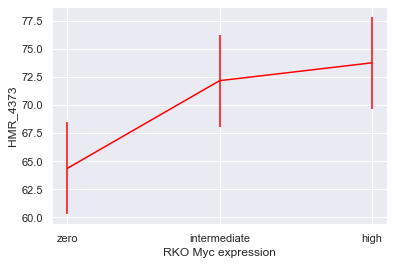

In [201]:
std_flux_plot('HMR_4373')

## Alternative methods for finding core reactions
### e.g. simulate knockouts, set bounds to zero, remove reaction from model (then add back in in loop)

# Running FVA on model. 

In [223]:
model = cobra.io.read_sbml_model('Human-GEM-annotated.xml')
model

Name,HumanGEM
Memory address,0x013bdd3400
Number of metabolites,8400
Number of reactions,13096
Number of groups,143
Objective expression,1.0*biomass_human - 1.0*biomass_human_reverse_fb2f2
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [226]:
model.objective = x('biomass_human')
FVA = cobra.flux_analysis.flux_variability_analysis(model)

In [239]:
FVA_reindexed.iloc[0,2]

nan

In [271]:
FVA

,minimum,maximum
HMR_3905,0.0,1000.000000
HMR_3907,0.0,1000.000000
HMR_4097,0.0,1000.000000
HMR_4099,0.0,1000.000000
HMR_4108,0.0,1000.000000
...,...,...
HMR_10128,0.0,1000.000000
HMR_10129,0.0,1000.000000
HMR_10130,0.0,1000.000000
HMR_10131,0.0,1000.000000


In [252]:
reaction_ids = []

for r in model.reactions:
    reaction_ids.append(r.id)
    
reaction_ids[0]

'HMR_3905'

In [253]:
FVA_reindexed = FVA.reindex(columns = FVA.columns.tolist() + ['Reaction ID'])

for n in range(13096):
    FVA_reindexed.iloc[n,2] = reaction_ids[n]

In [262]:
for value in FVA_reindexed['minimum']:
    print(value)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-386.6628486267824
0.0
0.12681967213114756
0.0
-1000.0
-1000.0
0.0
-1000.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
143.09211053864175
143.09211053864175
0.0
143.09211053864175
143.09211053864175
0.0
0.0
143.09211053864175
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
574.8103681498836
-425.1896318501163
0.0
-425.18963185011637
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
574.8103681498837
0.0
0.0
0.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
-53.82147238609127
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0


0.0
-86.02013249729292
-86.02013249729292
0.0
-1000.0
0.0
-86.0201324972929
-86.0201324972929
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-86.02013249729292
-86.02013249729292
-86.02013249729292
-86.02013249729292
-86.02013249729292
0.0
0.0
0.0
0.0
-86.02013249729292
-86.02013249729292
-86.02013249729292
0.0
0.0
0.0
-469.7327291888432
0.0
-1000.0
-469.73272918884334
-172.0402649945858
-524.7231852250411
-1000.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
-86.02013249729292
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
-86.0201324972929
-86.0201324972929
-86.0201324972929
-86.0201324972929
-1000.0
-86.0201324972929
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-524.723185225047
0.0
-386.5360289546512
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
-386.536028954651
-386.5360289546509
-386.5360289546512
-386.5360289546511
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-500.0
-1000.0
-500.0
0.0
-500.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.007756440281030445
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0038669789227166276
0.0038669789227166276
0.0
-999.992243559719
0.0
0.0
0.0
0.0
0.0038669789227166276
0.0
0.0
-0.0038669789227166267
0.0
0.0038669789227166276
0.0038669789227166276
0.0038669789227166276
0.0038669789227166276
0.0038669789227166276
-1000.0
-0.007733957845433253
-1000.0
-1000.0
0.0
0.0038669789227166276
0.0038669789227166276
0.0
0.0
0.0038669789227166276
0.0038669789227166276
0.0
0.0
-1000.0
-999.9922660421546
-1000.0
-1000.0
-1000.0
0.0038669789227166276
0.0038669789227166276
0.0
0.0
0.0
0.007756440281030445
0.0
0.0
0.0
0.0
0.00775644028103

-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
0.0
-1000.0
-1000.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0


0.0
0.0
0.0
0.0
0.0
-386.53602895465133
-386.53602895465133
-1000.0
-1000.0
0.0
-1000.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-386.53602895465144
0.0
-333.3333333333333
-340.46526208218
-1000.0
-1000.0
-255.348946561635
-340.46526208218
-255.348946561635
-510.69789312327003
-510.69789312327003
-170.23263104109
-85.116315520545
-1000.0
-0.02589231386662869
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-0.19258545979778527
-13.61677731539255
-1.9801980198019802
-0.07924067834248774
-0.05707856304705481
-0.7265714829974729
-0.08476667301637175
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
-1000.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
0.0
-1000.0
-1000.0
-1000.0
0

0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
-1000.0
0.0
-1000.0
0.0
-1000.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
-1000.0
0.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
-1000.0
0.0
0.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
-1000.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000.0
0.0
-425.18963185011637
-425.18963185011654
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-57.45805835812385
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
-132.87175995316133
0.0
0.0
-1000.0
-1000.0
-1000.0
-1000.0
-1000.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
-1000.0
0.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-386.53602895465133
0.0
-1000.0
0.0
0.0
0.0
0.0
-386.53602895465133
0.0
0.0
0.0
-386.53602895465133
-1000.0
0.0
0.0
-1000.0
0.0
0.0
0.0
0.0
-386.53602895465156
0.0
0.0
0.0
-386.53602895465133
0.0
-1000.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-386.53602895465133
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1000

In [263]:
core_reactions_FVA

for n in range(13096):
     if reaction in FVA_reindexed.iloc[:,0] != -1000:
            if reaction in FVA_reindexed.iloc[:,0] != 0:
                if reaction in FVA_reindexed.iloc[:,1] != 1000:
                    core_reactions_FVA.append(FVA_reindexed.iloc[:,2])
            
print(len(core_reactions_FVA))

0


## Calculating core reactions using FVA. 

# different ideas: optimise for growth in the std_flux_plot instead of target reaction? 
## Scrap model.objective = x(reaction) line in code. and keep solution.fluxes. 
## Try andors high first, what is the difference in flux. 
## Remove reactions where we don't have any data? 
## Could try percentiles for proteomics, e.g. if data is between 10 - 20, set bounds 10 - 20. 
## Nothing else? Move onto FVA and flux sampling. 